In [20]:
import pandas as pd
import numpy as np
import os
import sys
import configparser
import collections
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score

sys.path.append(os.path.abspath('../../Module'))
import preprocessing
import evaluation
import visualize

config = configparser.ConfigParser()
config.read('../../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

colors = preprocessing.basic_colors()
num_classes = 11

# Daten importieren

In [2]:
# Gezippte Numpy-Archive importieren
perceptron_arrays = np.load(vg_json_export+'baseline_arrays_bgr.npz')

train_x = perceptron_arrays['train_x']
train_y = perceptron_arrays['train_y']
test_x = perceptron_arrays['test_x']
test_y = perceptron_arrays['test_y']
dev_x = perceptron_arrays['dev_x']
dev_y = perceptron_arrays['dev_y']

In [3]:
rus = RandomUnderSampler(random_state=123)
test_x_res, test_y_res = rus.fit_resample(test_x[:,1:], test_y[:,1:].argmax(axis=1))
test_y_res = np.eye(11)[test_y_res]
dev_x_res, dev_y_res = rus.fit_resample(dev_x[:,1:], dev_y[:,1:].argmax(axis=1))
dev_y_res = np.eye(11)[dev_y_res]

In [11]:
def sampling_steps(count_list, array_x, array_y):
    """
    Gehe Werte in count_list durch
    gib für jeden Schritt ein Sample vom DataFrame aus, das für jede Farbkategorie 
    höchstens die Anzahl von Instanzen enthält, die dem aktuellen Wert in count_list entspricht
    Wenn weniger Instanzen für eine Klasse: Alle Instanzen der jeweiligen Klasse ausgeben
    """
    # Erfassen: Wieviele Instanzen / Farbe in gegebenen Arrays? DataFrame aus Arrays erzeugen
    color_values = array_y[:,1:].argmax(axis=1)
    color_values.shape = (len(color_values),1)
    df = pd.DataFrame(np.append(array_y, color_values, axis=1))
    color_counts_dict = dict(df.groupby([12]).size().reset_index(name='count').values)
    
    res_list = []
    
    # Über gegebene Werte iterieren
    for val in count_list:
        sample_df = pd.DataFrame(columns=df.columns)
        
        # Über Farbwerte iterieren
        for i in list(range(0,11)):
            # Maximalwert für jeweilige Farbe überprüfen
            color_count = len(df.loc[df[12] == i])
            # Anzahl der Samples: Gegebener Wert wenn kleiner/gleich Anzahl Farbinstanzen, sonst Anzahl Farbinstanzen; Samples zu sample_df
            n = (val if color_count >= val else color_count)
            sample_df = sample_df.append(df.loc[df[12] == i].sample(n, replace=False, random_state=123))
            
        # Einträge aus Input_Arrays auswählen, deren ID in sample_df ist
        out_x = pd.DataFrame(array_x).loc[pd.DataFrame(array_x)[0].isin(sample_df[0].values)].to_numpy()
        out_y = pd.DataFrame(array_y).loc[pd.DataFrame(array_y)[0].isin(sample_df[0].values)].to_numpy()
        # Ausgewählte Einträge als Set (x-array, y-array) zur Results-Liste hinzufügen
        res_list.append((out_x, out_y))
    return res_list

# Modell compilen, Funktionen definieren

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import numpy as np

batch_size = 128
epochs = 25

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(512,)))
model.add(Dropout(0.2))
model.add(Dense(240, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
def model_prediction(model, tr_x, tr_y, te_x, te_y):
    tr_x = (tr_x[:,1:] if tr_x.shape[1] == 513 else tr_x)
    te_x = (te_x[:,1:] if te_x.shape[1] == 513 else te_x)
    tr_y = (tr_y[:,1:] if tr_y.shape[1] == 12 else tr_y)
    te_y = (te_y[:,1:] if te_y.shape[1] == 12 else te_y)

    #print(tr_x.shape[0], 'train samples')
    #print(te_x.shape[0], 'test samples')

    history = model.fit(tr_x, tr_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(te_x, te_y))

    _predict_y = model.predict(te_x)
    
    return (_predict_y)

In [15]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, label_ranking_average_precision_score


steps = [5000,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,150000,200000]
predictions = []
input_arrays = []

accuracy_list = []
precision_list = []
recall_list = []
fscore_list = []

for i in sampling_steps(steps,train_x, train_y):
    input_arrays.append(i)
    x_res, y_res = i
    prediction = model_prediction(model, x_res, y_res, dev_x_res, dev_y_res)
    predictions.append(prediction)
    accuracy = accuracy_score(dev_y_res.argmax(axis=1), prediction.argmax(axis=1))
    precision,recall,fscore,support = precision_recall_fscore_support(dev_y_res.argmax(axis=1),prediction.argmax(axis=1),
                                                                  average='macro', warn_for=('precision', 'recall', 'f-score'))
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


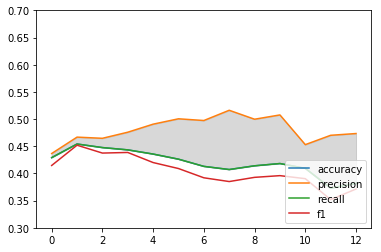

In [34]:
line1 = plt.plot(accuracy_list)
line2 = plt.plot(precision_list)
line3 = plt.plot(recall_list)
line4 = plt.plot(fscore_list)

axes = plt.gca()
axes.set_ylim([0.3,0.7])

plt.fill_between(np.arange(0,len(precision_list)),precision_list,recall_list,color='grey',alpha=0.3)

plt.legend(['accuracy','precision','recall','f1'], loc=4)

plt.show()

{'blue': 5000, 'brown': 5000, 'green': 5000, 'red': 5000, 'orange': 5000, 'yellow': 5000, 'pink': 5000, 'purple': 5000, 'black': 5000, 'white': 5000, 'gray': 5000}
Accuracy: 0.42907171983689135
              precision    recall  f1-score   support

       black       0.40      0.26      0.32      1895
        blue       0.37      0.64      0.47      1895
       brown       0.37      0.34      0.35      1895
        gray       0.37      0.22      0.27      1895
       green       0.56      0.49      0.52      1895
      orange       0.51      0.48      0.49      1895
        pink       0.59      0.46      0.52      1895
      purple       0.51      0.64      0.57      1895
         red       0.49      0.42      0.45      1895
       white       0.30      0.11      0.16      1895
      yellow       0.32      0.67      0.43      1895

   micro avg       0.43      0.43      0.43     20845
   macro avg       0.44      0.43      0.41     20845
weighted avg       0.44      0.43      0.41     

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'blue': 10000, 'brown': 10000, 'green': 10000, 'red': 10000, 'orange': 10000, 'yellow': 10000, 'pink': 10000, 'purple': 6463, 'black': 10000, 'white': 10000, 'gray': 10000}
Accuracy: 0.45416166946509956
              precision    recall  f1-score   support

       black       0.32      0.45      0.37      1895
        blue       0.49      0.54      0.51      1895
       brown       0.37      0.40      0.38      1895
        gray       0.37      0.29      0.32      1895
       green       0.57      0.52      0.54      1895
      orange       0.57      0.45      0.50      1895
        pink       0.44      0.71      0.54      1895
      purple       0.72      0.46      0.57      1895
         red       0.45      0.50      0.47      1895
       white       0.28      0.20      0.23      1895
      yellow       0.55      0.49      0.52      1895

   micro avg       0.45      0.45      0.45     20845
   macro avg       0.47      0.45      0.45     20845
weighted avg       0.47      0.45     

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'blue': 20000, 'brown': 20000, 'green': 20000, 'red': 20000, 'orange': 18691, 'yellow': 20000, 'pink': 12285, 'purple': 6463, 'black': 20000, 'white': 20000, 'gray': 20000}
Accuracy: 0.44758934996402017
              precision    recall  f1-score   support

       black       0.41      0.31      0.35      1895
        blue       0.47      0.57      0.51      1895
       brown       0.36      0.43      0.39      1895
        gray       0.40      0.21      0.28      1895
       green       0.50      0.61      0.55      1895
      orange       0.60      0.40      0.48      1895
        pink       0.37      0.71      0.49      1895
      purple       0.76      0.42      0.54      1895
         red       0.40      0.55      0.46      1895
       white       0.31      0.17      0.22      1895
      yellow       0.53      0.54      0.54      1895

   micro avg       0.45      0.45      0.45     20845
   macro avg       0.46      0.45      0.44     20845
weighted avg       0.46      0.45     

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'blue': 30000, 'brown': 30000, 'green': 30000, 'red': 30000, 'orange': 18691, 'yellow': 30000, 'pink': 12285, 'purple': 6463, 'black': 30000, 'white': 30000, 'gray': 21481}
Accuracy: 0.44336771408011516
              precision    recall  f1-score   support

       black       0.36      0.37      0.37      1895
        blue       0.47      0.56      0.51      1895
       brown       0.34      0.46      0.39      1895
        gray       0.41      0.18      0.25      1895
       green       0.51      0.60      0.55      1895
      orange       0.60      0.43      0.50      1895
        pink       0.64      0.48      0.55      1895
      purple       0.80      0.37      0.51      1895
         red       0.47      0.53      0.50      1895
       white       0.31      0.22      0.25      1895
      yellow       0.33      0.68      0.45      1895

   micro avg       0.44      0.44      0.44     20845
   macro avg       0.48      0.44      0.44     20845
weighted avg       0.48      0.44     

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'blue': 40000, 'brown': 40000, 'green': 40000, 'red': 40000, 'orange': 18691, 'yellow': 38351, 'pink': 12285, 'purple': 6463, 'black': 40000, 'white': 40000, 'gray': 21481}
Accuracy: 0.43564403933797075
              precision    recall  f1-score   support

       black       0.31      0.43      0.36      1895
        blue       0.41      0.65      0.50      1895
       brown       0.30      0.55      0.39      1895
        gray       0.48      0.07      0.13      1895
       green       0.48      0.64      0.55      1895
      orange       0.69      0.34      0.45      1895
        pink       0.63      0.45      0.53      1895
      purple       0.86      0.29      0.44      1895
         red       0.43      0.59      0.50      1895
       white       0.30      0.20      0.24      1895
      yellow       0.50      0.58      0.54      1895

   micro avg       0.44      0.44      0.44     20845
   macro avg       0.49      0.44      0.42     20845
weighted avg       0.49      0.44     

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'blue': 50000, 'brown': 50000, 'green': 50000, 'red': 50000, 'orange': 18691, 'yellow': 38351, 'pink': 12285, 'purple': 6463, 'black': 50000, 'white': 50000, 'gray': 21481}
Accuracy: 0.4262413048692732
              precision    recall  f1-score   support

       black       0.29      0.52      0.37      1895
        blue       0.43      0.64      0.52      1895
       brown       0.31      0.49      0.38      1895
        gray       0.55      0.04      0.08      1895
       green       0.52      0.59      0.55      1895
      orange       0.74      0.28      0.40      1895
        pink       0.69      0.34      0.45      1895
      purple       0.83      0.32      0.47      1895
         red       0.39      0.63      0.48      1895
       white       0.27      0.24      0.25      1895
      yellow       0.49      0.60      0.54      1895

   micro avg       0.43      0.43      0.43     20845
   macro avg       0.50      0.43      0.41     20845
weighted avg       0.50      0.43      

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'blue': 60000, 'brown': 60000, 'green': 60000, 'red': 60000, 'orange': 18691, 'yellow': 38351, 'pink': 12285, 'purple': 6463, 'black': 60000, 'white': 60000, 'gray': 21481}
Accuracy: 0.41300071959702567
              precision    recall  f1-score   support

       black       0.36      0.38      0.37      1895
        blue       0.45      0.60      0.51      1895
       brown       0.32      0.50      0.39      1895
        gray       0.52      0.03      0.05      1895
       green       0.46      0.67      0.54      1895
      orange       0.73      0.25      0.37      1895
        pink       0.63      0.31      0.41      1895
      purple       0.87      0.26      0.41      1895
         red       0.32      0.73      0.44      1895
       white       0.27      0.32      0.29      1895
      yellow       0.55      0.50      0.52      1895

   micro avg       0.41      0.41      0.41     20845
   macro avg       0.50      0.41      0.39     20845
weighted avg       0.50      0.41     

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'blue': 70000, 'brown': 61517, 'green': 70000, 'red': 67760, 'orange': 18691, 'yellow': 38351, 'pink': 12285, 'purple': 6463, 'black': 70000, 'white': 70000, 'gray': 21481}
Accuracy: 0.40719597025665627
              precision    recall  f1-score   support

       black       0.27      0.60      0.37      1895
        blue       0.43      0.63      0.51      1895
       brown       0.33      0.43      0.37      1895
        gray       0.62      0.01      0.02      1895
       green       0.46      0.67      0.55      1895
      orange       0.78      0.21      0.33      1895
        pink       0.66      0.33      0.44      1895
      purple       0.86      0.28      0.42      1895
         red       0.36      0.67      0.47      1895
       white       0.27      0.26      0.26      1895
      yellow       0.64      0.39      0.48      1895

   micro avg       0.41      0.41      0.41     20845
   macro avg       0.52      0.41      0.39     20845
weighted avg       0.52      0.41     

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'blue': 72893, 'brown': 61517, 'green': 72974, 'red': 67760, 'orange': 18691, 'yellow': 38351, 'pink': 12285, 'purple': 6463, 'black': 80000, 'white': 80000, 'gray': 21481}
Accuracy: 0.41405612856800195
              precision    recall  f1-score   support

       black       0.27      0.57      0.37      1895
        blue       0.43      0.61      0.51      1895
       brown       0.32      0.45      0.38      1895
        gray       0.50      0.01      0.02      1895
       green       0.42      0.72      0.53      1895
      orange       0.76      0.24      0.37      1895
        pink       0.66      0.37      0.48      1895
      purple       0.84      0.29      0.43      1895
         red       0.40      0.61      0.48      1895
       white       0.28      0.25      0.26      1895
      yellow       0.61      0.43      0.50      1895

   micro avg       0.41      0.41      0.41     20845
   macro avg       0.50      0.41      0.39     20845
weighted avg       0.50      0.41     

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'blue': 72893, 'brown': 61517, 'green': 72974, 'red': 67760, 'orange': 18691, 'yellow': 38351, 'pink': 12285, 'purple': 6463, 'black': 90000, 'white': 90000, 'gray': 21481}
Accuracy: 0.41822979131686255
              precision    recall  f1-score   support

       black       0.30      0.50      0.38      1895
        blue       0.42      0.65      0.51      1895
       brown       0.33      0.46      0.39      1895
        gray       0.60      0.01      0.01      1895
       green       0.46      0.67      0.55      1895
      orange       0.72      0.27      0.39      1895
        pink       0.69      0.30      0.42      1895
      purple       0.86      0.28      0.42      1895
         red       0.38      0.64      0.48      1895
       white       0.25      0.30      0.27      1895
      yellow       0.57      0.52      0.54      1895

   micro avg       0.42      0.42      0.42     20845
   macro avg       0.51      0.42      0.40     20845
weighted avg       0.51      0.42     

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'blue': 72893, 'brown': 61517, 'green': 72974, 'red': 67760, 'orange': 18691, 'yellow': 38351, 'pink': 12285, 'purple': 6463, 'black': 100000, 'white': 100000, 'gray': 21481}
Accuracy: 0.40935476133365317
              precision    recall  f1-score   support

       black       0.31      0.47      0.37      1895
        blue       0.43      0.62      0.51      1895
       brown       0.34      0.40      0.37      1895
        gray       0.00      0.00      0.00      1895
       green       0.49      0.63      0.55      1895
      orange       0.72      0.28      0.41      1895
        pink       0.65      0.30      0.41      1895
      purple       0.88      0.25      0.39      1895
         red       0.37      0.65      0.47      1895
       white       0.23      0.41      0.29      1895
      yellow       0.56      0.49      0.52      1895

   micro avg       0.41      0.41      0.41     20845
   macro avg       0.45      0.41      0.39     20845
weighted avg       0.45      0.41   

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Mean Reciprocal Rank: 0.5843856548558041 



/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'blue': 72893, 'brown': 61517, 'green': 72974, 'red': 67760, 'orange': 18691, 'yellow': 38351, 'pink': 12285, 'purple': 6463, 'black': 124920, 'white': 150000, 'gray': 21481}
Accuracy: 0.3729911249700168
              precision    recall  f1-score   support

       black       0.27      0.59      0.37      1895
        blue       0.47      0.52      0.50      1895
       brown       0.39      0.27      0.32      1895
        gray       0.00      0.00      0.00      1895
       green       0.50      0.60      0.55      1895
      orange       0.79      0.19      0.30      1895
        pink       0.69      0.20      0.31      1895
      purple       0.89      0.20      0.33      1895
         red       0.33      0.68      0.44      1895
       white       0.20      0.48      0.28      1895
      yellow       0.64      0.37      0.47      1895

   micro avg       0.37      0.37      0.37     20845
   macro avg       0.47      0.37      0.35     20845
weighted avg       0.47      0.37    

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Mean Reciprocal Rank: 0.5537798624977863 



/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


{'blue': 72893, 'brown': 61517, 'green': 72974, 'red': 67760, 'orange': 18691, 'yellow': 38351, 'pink': 12285, 'purple': 6463, 'black': 124920, 'white': 195225, 'gray': 21481}
Accuracy: 0.3816742624130487
              precision    recall  f1-score   support

       black       0.29      0.55      0.38      1895
        blue       0.49      0.47      0.48      1895
       brown       0.39      0.28      0.33      1895
        gray       0.00      0.00      0.00      1895
       green       0.49      0.60      0.54      1895
      orange       0.78      0.21      0.33      1895
        pink       0.66      0.32      0.43      1895
      purple       0.89      0.23      0.36      1895
         red       0.41      0.58      0.48      1895
       white       0.18      0.58      0.28      1895
      yellow       0.63      0.40      0.49      1895

   micro avg       0.38      0.38      0.38     20845
   macro avg       0.47      0.38      0.37     20845
weighted avg       0.47      0.38    

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Mean Reciprocal Rank: 0.560559148348796 



/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


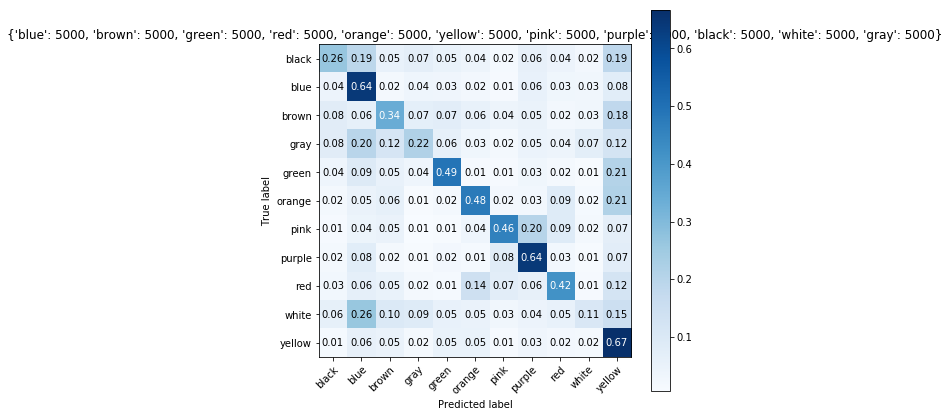

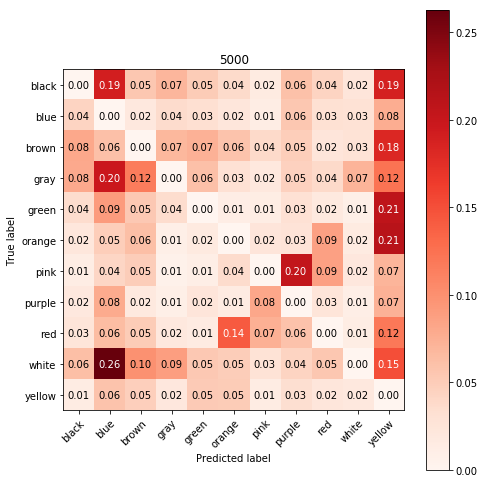

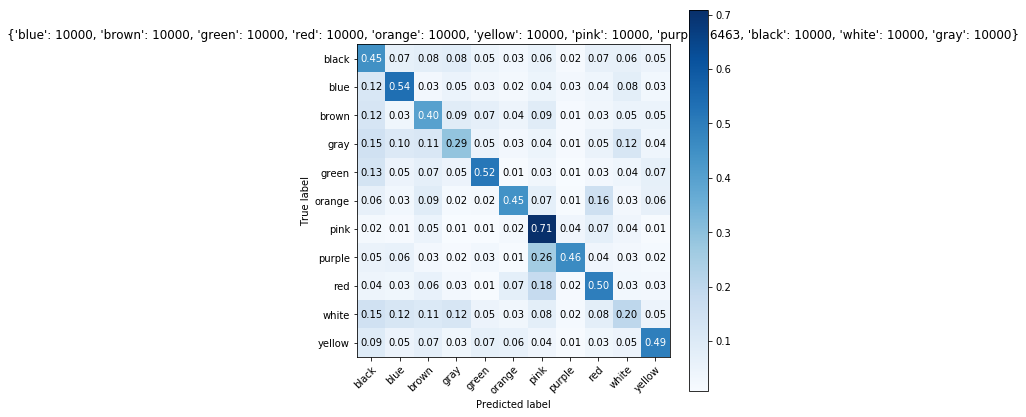

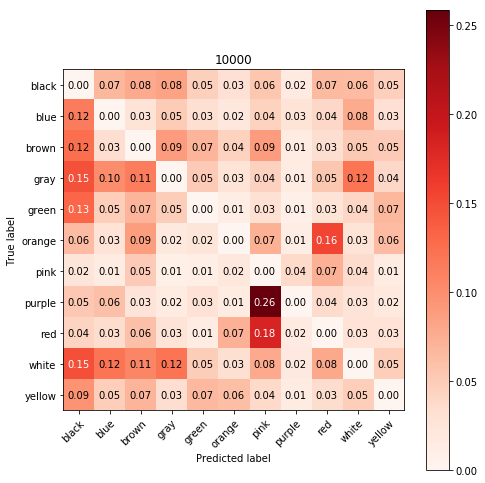

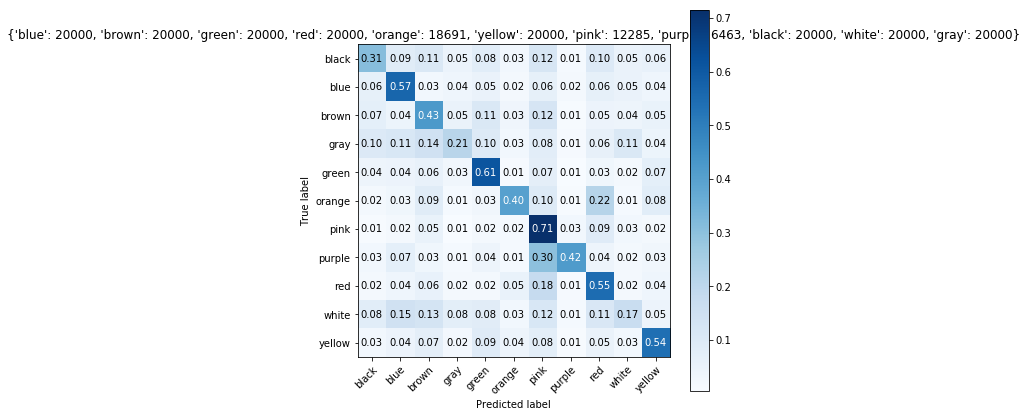

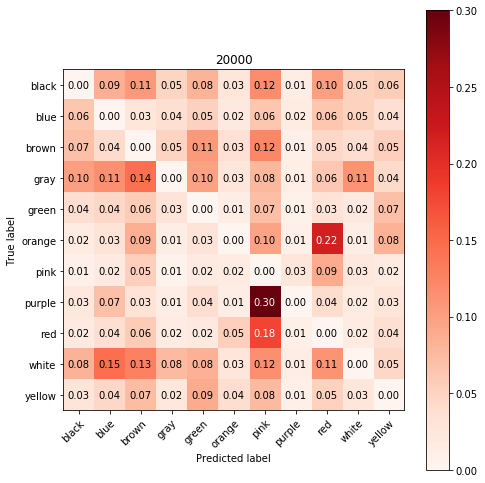

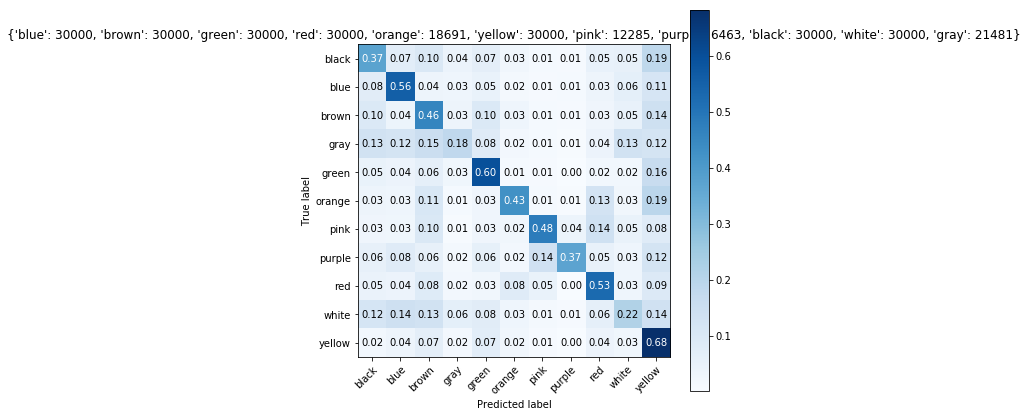

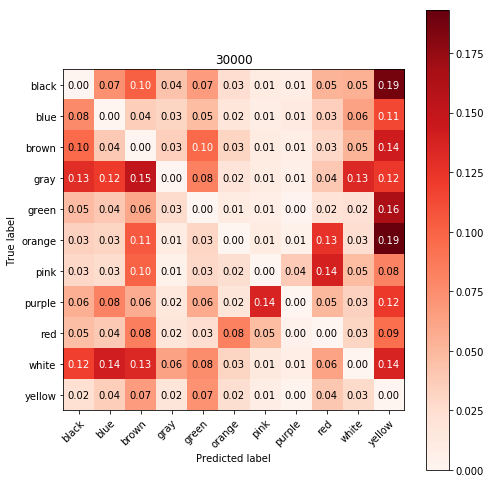

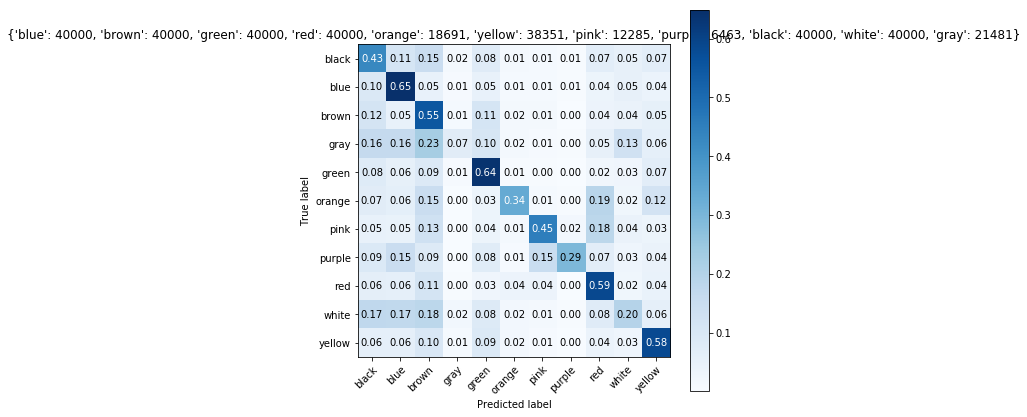

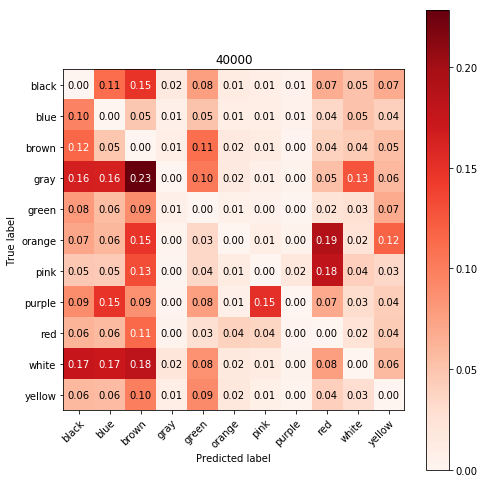

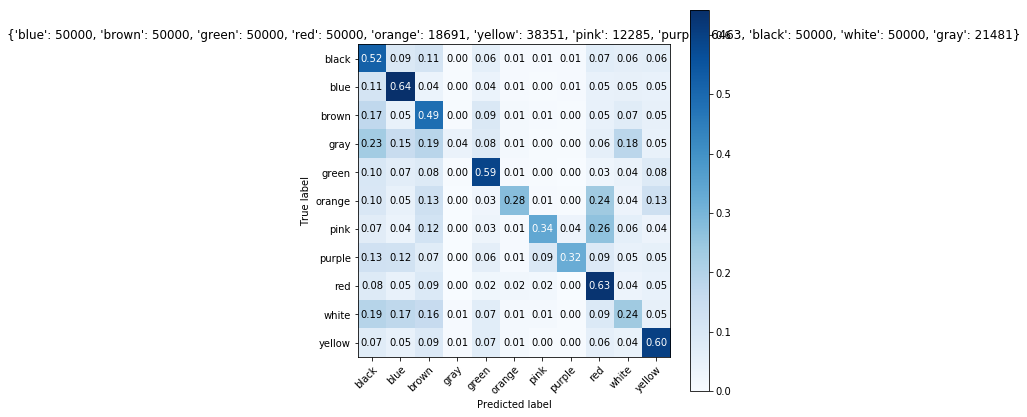

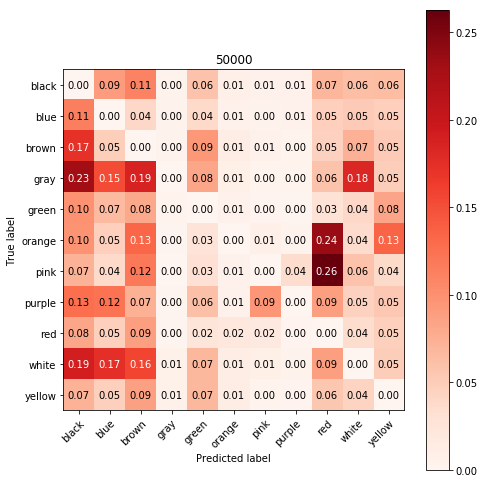

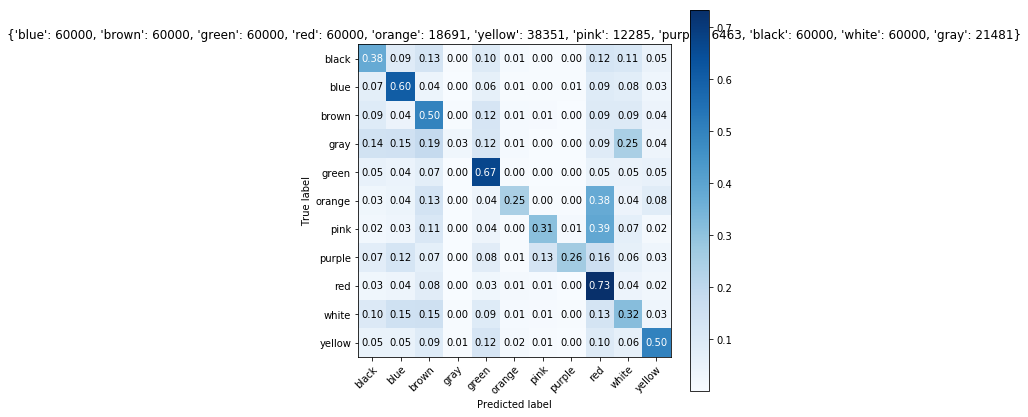

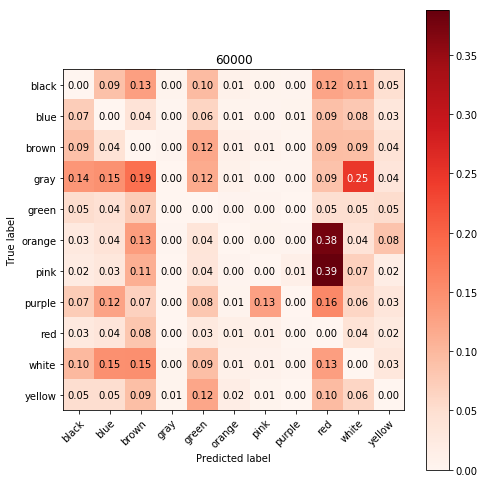

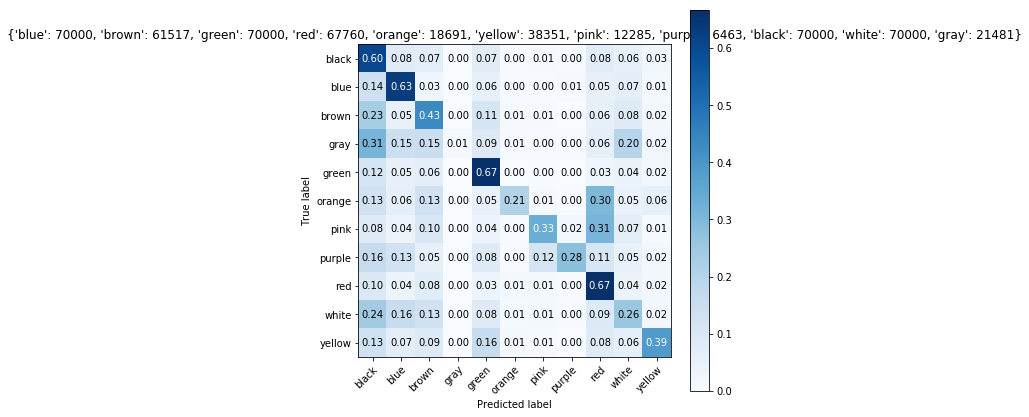

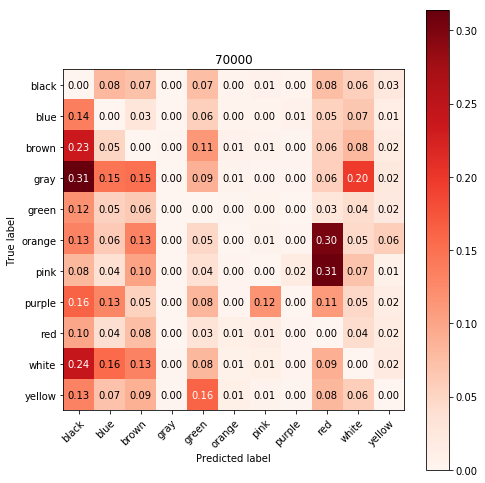

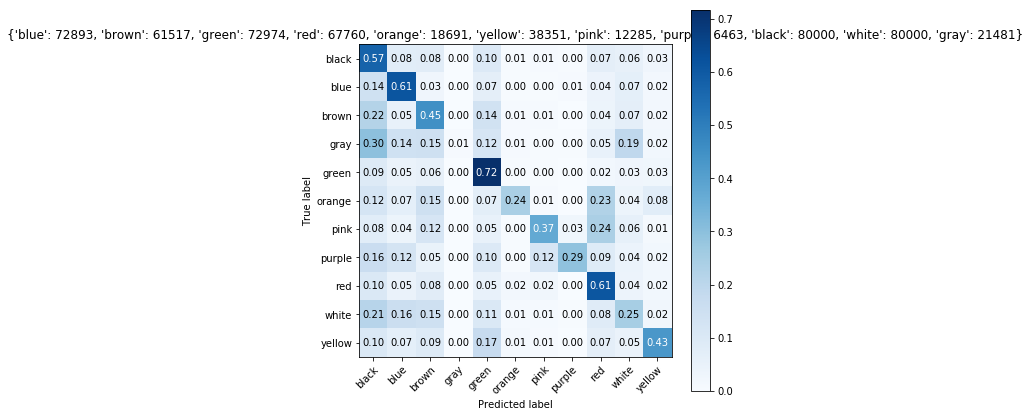

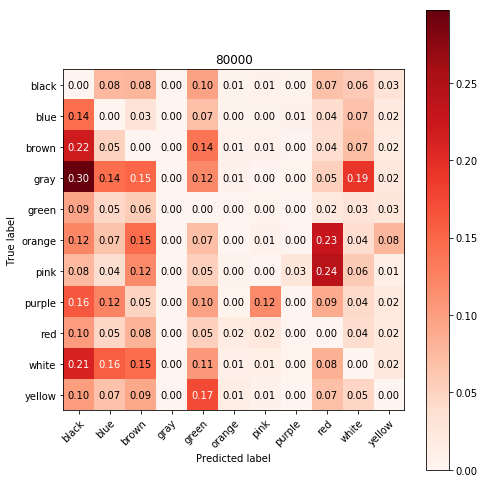

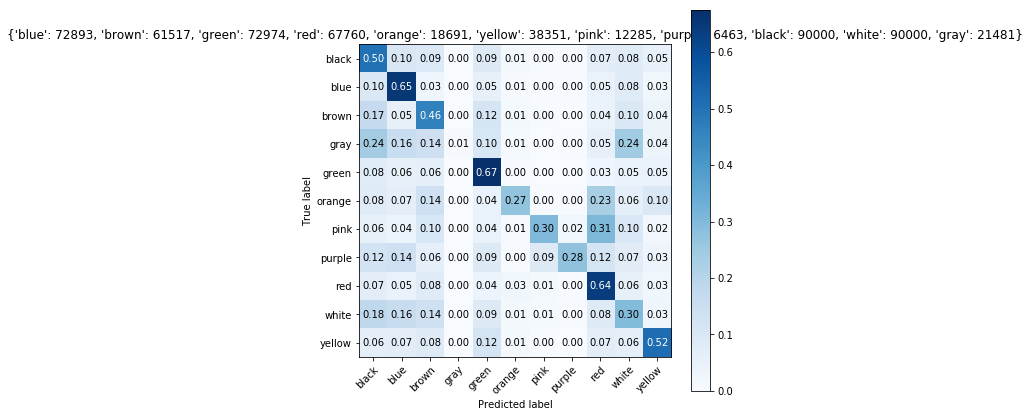

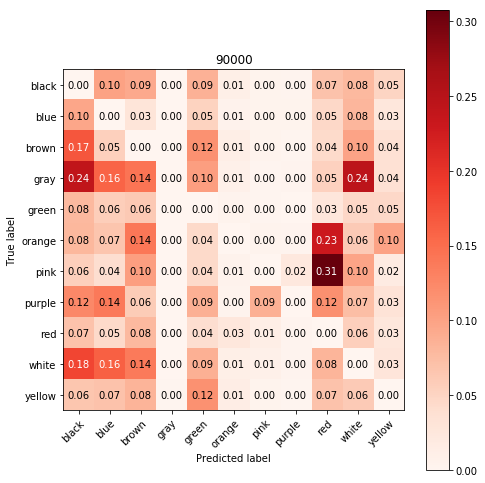

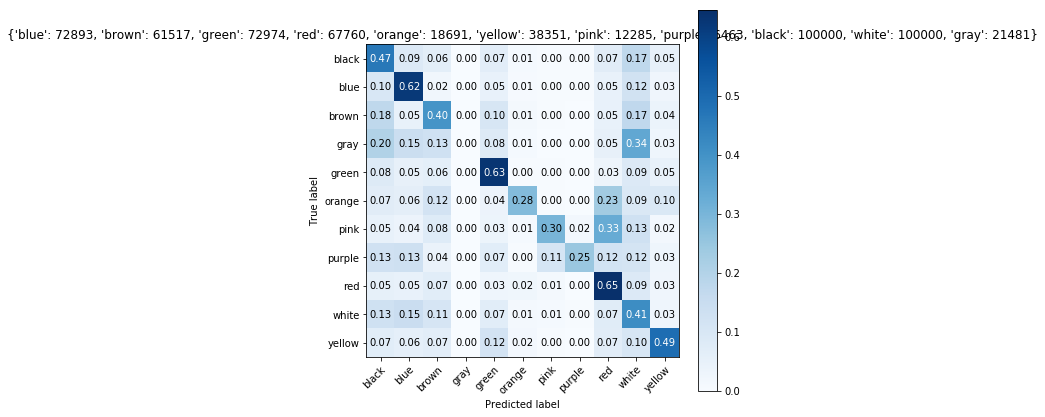

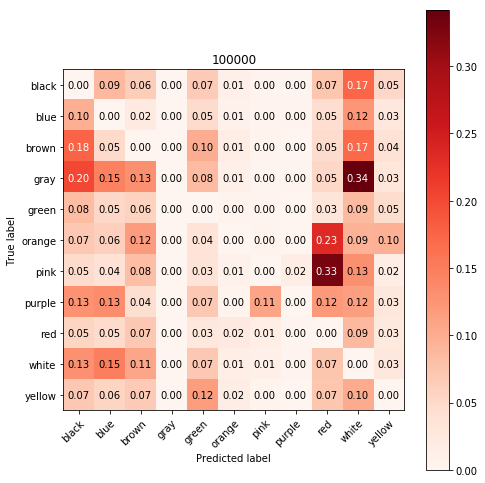

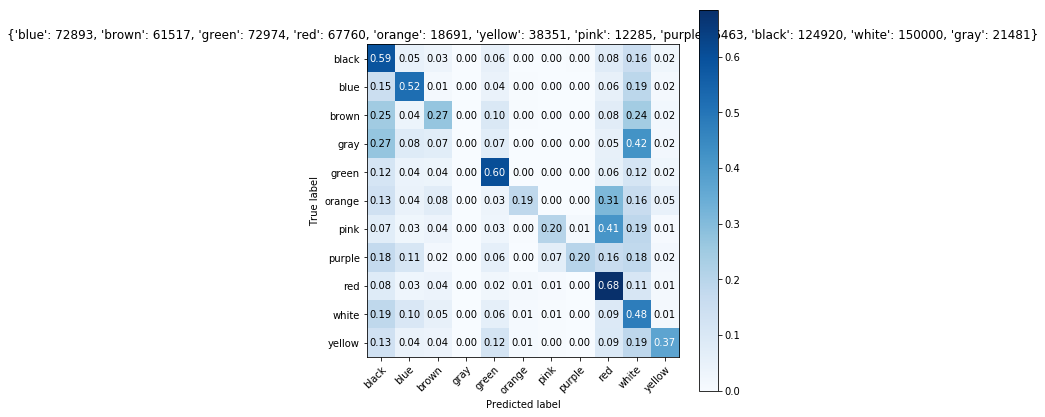

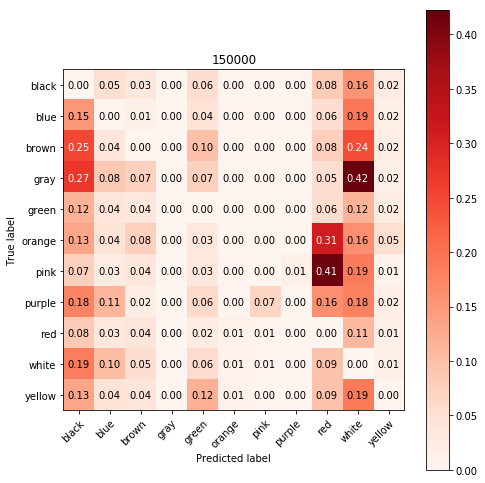

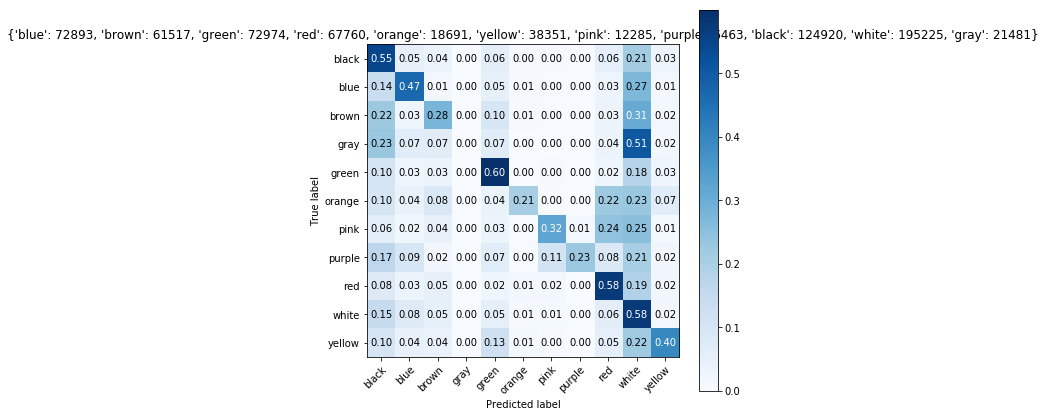

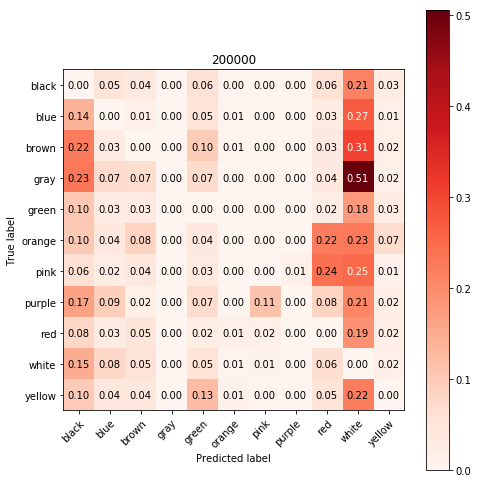

In [26]:
n = 0
for p in predictions:
    number_items = list(collections.Counter(input_arrays[n][1][:,1:].argmax(axis=1)).values())
    items = dict(zip(colors, number_items))
    print (items)
    print ('Accuracy:', accuracy_score(dev_y_res.argmax(axis=1),p.argmax(axis=1), normalize=True, sample_weight=None))
    print (classification_report(dev_y_res.argmax(axis=1),p.argmax(axis=1), 
                             labels=None, target_names=colors, sample_weight=None, digits=2, output_dict=False))
    print ('Mean Reciprocal Rank:',label_ranking_average_precision_score(dev_y_res,p),'\n')
    evaluation.plot_confusion_matrix(dev_y_res.argmax(axis=1),p.argmax(axis=1), colors, title=items)
    evaluation.plot_confusion_matrix(dev_y_res.argmax(axis=1),p.argmax(axis=1), colors, error_matrix=True, cmap=plt.cm.Reds, title=steps[n])
    n += 1

In [29]:
%store steps
%store predictions
%store accuracy_list
%store precision_list
%store recall_list
%store fscore_list

Stored 'steps' (list)
Stored 'predictions' (list)
Stored 'accuracy_list' (list)
Stored 'precision_list' (list)
Stored 'recall_list' (list)
Stored 'fscore_list' (list)
